# The User Interface of our robot.

In [1]:
from ipywidgets import VBox,HBox
import ipywidgets as widgets
import jupyros as jr
import rospy
from IPython.display import display, clear_output
import time
import numpy as np
import rospy
import actionlib
import actionlib.msg
import assignment_2_2022.msg
from std_srvs.srv import *
import sys
import select
from nav_msgs.msg import Odometry
from geometry_msgs.msg import Point, Pose, Twist
from assignment_2_2022.msg import Posxy_velxy
from colorama import Fore, Style
from colorama import init
from sensor_msgs.msg import LaserScan 


## Declaration of pusblishers.

In [2]:
pub = rospy.Publisher("/posxy_velxy", Posxy_velxy, queue_size=1)
velocity_publisher = rospy.Publisher('cmd_vel',Twist, queue_size=10) 
rospy.init_node('user_interface', anonymous=True)

inputt=Posxy_velxy()
velocity=Twist()
action_client = actionlib.SimpleActionClient('/reaching_goal', assignment_2_2022.msg.PlanningAction)

## Callback function of LaserScan to get the distance of the obstacles

In [3]:
#min1=[]
#min2=[]
#min3=[]

def odom_callback(msg):
    global min1, min2, min3
    min1 = msg.ranges[300] #front
    min2 = msg.ranges[660] #left
    min3 = msg.ranges[0] #right

jr.subscribe('/scan', LaserScan, odom_callback)
dist_button = widgets.Button(description="Nearset obstacle!", button_style='' 'success' '')
dist_output = widgets.Output(layout={'border': '1px solid black'})

def on_button_distance(b):
    distFront=min1
    distLeft =min2
    distRight=min3
    with dist_output:
            clear_output()
            if distFront<distLeft and distFront<distRight:
                print('The nearest obstacle is on the  Front with \n        ')
                print('a distance =  ',distFront)
            if distLeft<distFront and distLeft<distRight:
                print('The nearest obstacle is on the Left with  \n        ')
                print('a distance = ',distLeft)
            if distRight<distFront and distRight<distLeft:    
                print('The nearest obstacle is on the Right with  \n    ')
                print('a distance = ',distRight)

dist_button.on_click(on_button_distance)

## Widgets and buttons' events

In [4]:
x_axis=widgets.BoundedFloatText(value=1.0,min=-20.0,max=20.0, step=0.1,description='x_axix:',disabled=False)
y_axis=widgets.BoundedFloatText(value=1.0,min=-20.0,max=20.0, step=0.1,description='y_axix:',disabled=False)

button1 = widgets.Button(description="Go!", button_style='' 'danger' '')
output = widgets.Output(layout={'border': '1px solid black'})

empty_space= widgets.Output()
with empty_space:
    print("                 ")

## Moving the robot by buttons.

In [5]:
def on_button_clicked1(b):
        
        goal = assignment_2_2022.msg.PlanningGoal()
        goal.target_pose.pose.position.x = x_axis.value
        goal.target_pose.pose.position.y = y_axis.value
        action_client.send_goal(goal)
        status_goal = True
        with output:
            clear_output()
            print('Your goal is x= (',x_axis.value,',',y_axis.value,')')
button1.on_click(on_button_clicked1)


## Buttons' layout.

In [6]:
row1=HBox([button1,empty_space,empty_space,empty_space,dist_button])
row2=HBox([x_axis,empty_space,empty_space,dist_output])
row3=HBox([y_axis])
row4=HBox([output])
row5=HBox([empty_space])
display(VBox([row1,row2,row3,row4,row5]))

## Plotting the robot's position and target and the number of reached/unreached targets.

<IPython.core.display.Javascript object>


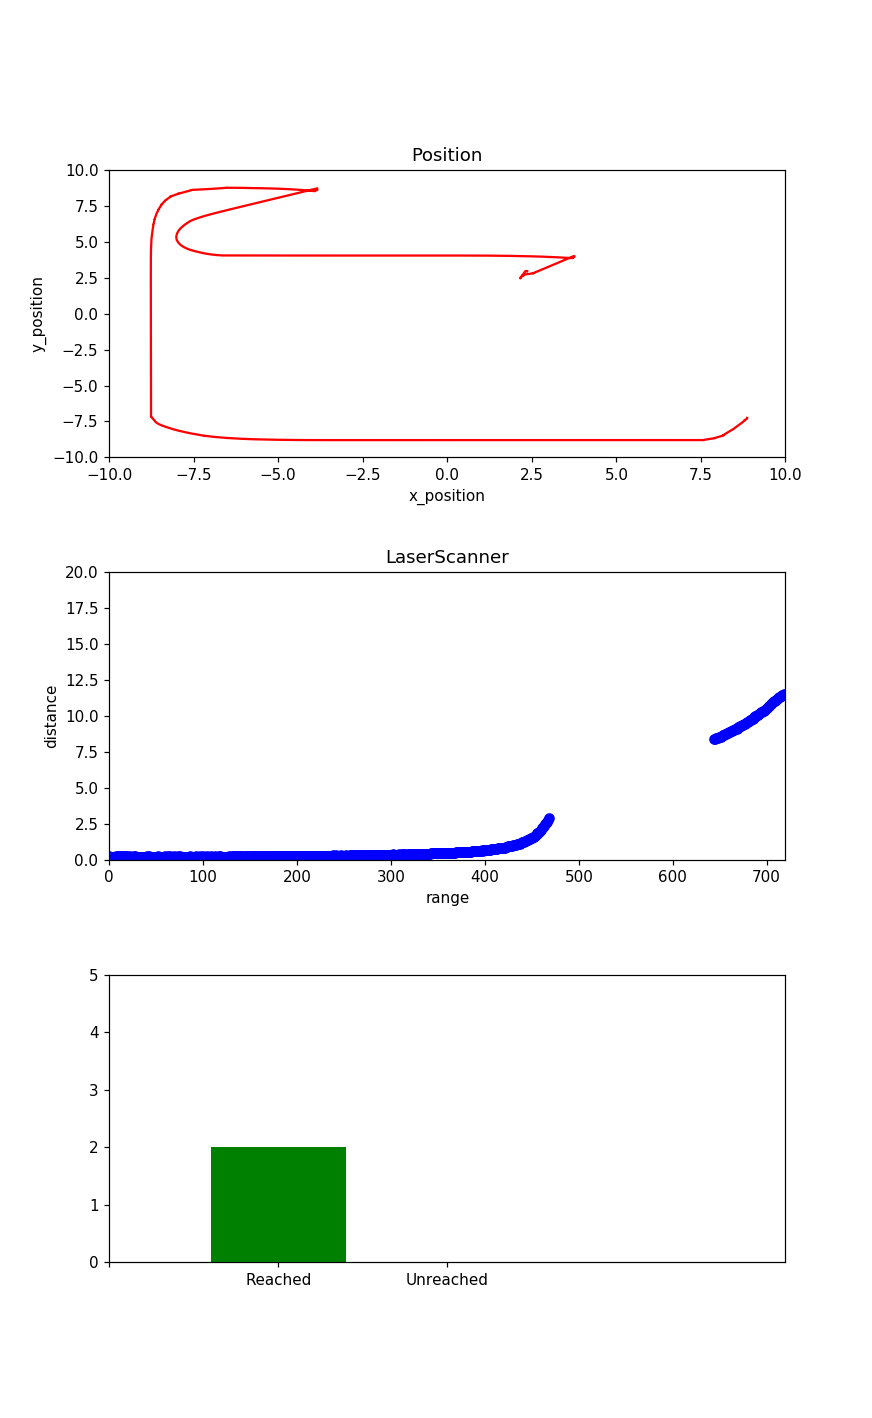

In [7]:
%matplotlib notebook
import matplotlib.pyplot as plt
import rospy
from nav_msgs.msg import Odometry
from sensor_msgs.msg import LaserScan
from assignment_2_2022.msg import PlanningFeedback
from matplotlib.animation import FuncAnimation

class Visualiser:
    def __init__(self):
        self.fig, self.ax = plt.subplots(3, 1, figsize=(8, 13))
        self.ln, = self.ax[0].plot([], [], 'r')
        self.x_dist = []
        self.y_dist = [] 
   
        self.ln2, = self.ax[1].plot([], [], 'bo')
        self.x_data = range(720)
        self.y_data = [0] * 720

        self.x = [" ", "Reached", "Unreached"]
        self.y = [0, 0, 0]

        self.ln3 = self.ax[2].bar(self.x, self.y, color='green')

        self.i = 0
        self.j = 0
        self.k1 = 0
        self.k2 = 0

    def plot_init(self):
        self.ax[0].set_xlim(-10, 10)
        self.ax[0].set_ylim(-10, 10)
        self.ax[0].set_title('Position')
        self.ax[0].set_xlabel('x_position')
        self.ax[0].set_ylabel('y_position')

        self.ax[1].set_xlim(0, 720)
        self.ax[1].set_ylim(0, 20)  
        self.ax[1].set_title('LaserScanner')
        self.ax[1].set_xlabel('range')
        self.ax[1].set_ylabel('distance')

        self.ax[2].set_xlim(0, 4)
        self.ax[2].set_ylim(0, 5)

        return self.ln, self.ln2, self.ln3

    def odom_callback(self, msg):
        self.y_dist.append(msg.pose.pose.position.y)
        self.x_dist.append(msg.pose.pose.position.x)

    def scan_callback(self, msg):
        self.y_data = msg.ranges

    def goal_status_callback(self, msg):
        if msg.feedback.stat == "Target reached!":
            self.i += 1
            self.k1 = 1
            self.k2 = 0
            print("Target reached!")
        elif msg.feedback.stat == "Target unreached!":
            self.j += 1
            self.k2 = 1
            self.k1 = 0
            print("Target unreached!")
        else:
            self.k1 = 0
            self.k2 = 0
            print("Other status")

        self.y = [0, self.i, self.j]
        self.ln3 = self.ax[2].bar(self.x, self.y, color='green')

    def update_plot(self, frame):
        self.ln.set_data(self.x_dist, self.y_dist)
        self.ln2.set_data(self.x_data, self.y_data)

        return self.ln, self.ln2, self.ln3



vis = Visualiser()
sub2 = rospy.Subscriber('/scan', LaserScan, vis.scan_callback)
sub3 = rospy.Subscriber('/reaching_goal/feedback', PlanningFeedback, vis.goal_status_callback)
sub = rospy.Subscriber('/odom', Odometry, vis.odom_callback)

ani = FuncAnimation(vis.fig, vis.update_plot, init_func=vis.plot_init)
plt.subplots_adjust(hspace=0.4)
plt.show(block=True)
